c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from dataset import *

levels = None
img_size = 300

#model = create_progressive_fusion_unet(n_fusion_levels=levels)
dataset = get_dataset(basedir='../data/FusedDataset', size=img_size, levels=levels)


c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/FusedDataset'

In [3]:
train_loader, val_loader, test_loader = dataset

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """double conv with optional residual connection"""
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Down(nn.Module):
    """downscaling with maxpool then double conv"""
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)


class Up(nn.Module):
    """upscaling then double conv"""
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class ProgressiveFusionDynamicUNet(nn.Module):
    """progressive fusion u-net with dynamic outputs for OCT denoising"""
    def __init__(self, n_channels: int = 1, base_features: int = 32, use_fusion: bool = True) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.use_fusion = use_fusion
        
        # Encoder pathway
        self.inc = DoubleConv(n_channels, base_features)
        self.down1 = Down(base_features, base_features * 2)
        self.down2 = Down(base_features * 2, base_features * 4)
        self.down3 = Down(base_features * 4, base_features * 8)

        # Fusion attention mechanism (optional)
        if use_fusion:
            self.fusion_attention = nn.Sequential(
                nn.Conv2d(base_features * 8, base_features * 8, kernel_size=1),
                nn.Sigmoid()
            )

        # Decoder pathway
        self.up1 = Up(base_features * 8, base_features * 4)
        self.up2 = Up(base_features * 4, base_features * 2)
        self.up3 = Up(base_features * 2, base_features)

        # Output layer
        self.outc = nn.Conv2d(base_features, n_channels, kernel_size=1)

        # Learnable parameters
        self.residual_weight = nn.Parameter(torch.tensor(0.2))

    def forward(self, x: torch.Tensor, n_targets: int, target_size: torch.Size):
        # Store input for residual connection
        input_image = x

        # Encoder pathway with skip connections
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        # Apply fusion attention if enabled
        if self.use_fusion:
            x4 = x4 * self.fusion_attention(x4)

        # Decoder pathway with skip connections
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)

        # Dynamically generate outputs for each target
        outputs = [
            (1 - self.residual_weight) * F.interpolate(self.outc(x), size=target_size[-2:], mode='bilinear', align_corners=False)
            + self.residual_weight * input_image
            for _ in range(n_targets)
        ]
        return outputs


def create_progressive_fusion_dynamic_unet(base_features: int = 32, use_fusion: bool = True) -> ProgressiveFusionDynamicUNet:
    """Factory function to create progressive fusion dynamic u-net"""
    return ProgressiveFusionDynamicUNet(n_channels=1, base_features=base_features, use_fusion=use_fusion)


In [5]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import torch.nn.functional as F
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

from modelling.utils import save_checkpoint, normalize_to_target
from modelling.loss import *
from modelling.visualisation import *

class Trainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        learning_rate=1e-4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        checkpoint_dir=f'checkpoints',
        img_size=300,
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
        self.img_size = img_size

        self.vis_dir = Path('visualizations')
        self.vis_dir.mkdir(exist_ok=True)
        
        self.optimizer = Adam(model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10, verbose=True
        )
        
        self.l1_loss = L1Loss()
        self.history = {'train_loss': [], 'val_loss': []}

    def train(self, num_epochs):
        best_val_loss = float('inf')
        
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(epoch)
            self.history['train_loss'].append(train_loss)
            
            val_loss = self.validate()
            self.history['val_loss'].append(val_loss)
            
            self.scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_checkpoint(epoch, val_loss, self.model, self.optimizer, self.checkpoint_dir, self.img_size)
            
            print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
            #plot_losses(self.history, self.vis_dir)
        return self.history

    def train_epoch(self, epoch):
        self.model.train()
        epoch_losses = []
        
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader), desc=f'Epoch {epoch}')
        
        for batch_idx, (data, _) in pbar:
            data = data.to(self.device)
            num_levels = data.shape[1] - 1
            batch_loss = 0
            
            self.optimizer.zero_grad() 
            
            input_img = data[:, 0, :, :, :]  # Input image
            target_images = [data[:, i, :, :, :] for i in range(1, num_levels + 1)]  # Targets
            
            # Forward pass with dynamic levels
            outputs = self.model(input_img, num_levels, target_images[0].shape)
            
            # Compute loss dynamically
            for output, target in zip(outputs, target_images):
                output = normalize_to_target(output, target)
                batch_loss += self.l1_loss(output, target)
            batch_loss /= num_levels
            
            # Backward pass
            batch_loss.backward()
            self.optimizer.step()
            
            epoch_losses.append(batch_loss.item())
            pbar.set_postfix({'loss': f"{sum(epoch_losses) / len(epoch_losses):.4f}"})
            
            if batch_idx % 100 == 0:
                #visualize_batch(epoch, batch_idx, input_img, outputs, target_images, self.vis_dir)
                save_batch(epoch, batch_idx, input_img, outputs, target_images, "saved_batches")
        
        return sum(epoch_losses) / len(epoch_losses)

    def validate(self):
        self.model.eval()
        val_losses = []
        
        with torch.no_grad():
            for data, _ in tqdm(self.val_loader, desc='Validating'):
                data = data.to(self.device)
                
                input_img = data[:, 0, :, :, :]  # Input image
                num_levels = data.shape[1] - 1
                target_images = [data[:, i, :, :, :] for i in range(1, num_levels + 1)]  # Targets
                
                # Forward pass
                outputs = self.model(input_img, num_levels, target_images[0].shape)
                
                # Compute loss
                batch_loss = 0
                for output, target in zip(outputs, target_images):
                    output = normalize_to_target(output, target)
                    batch_loss += self.l1_loss(output, target)
                batch_loss /= num_levels
                
                val_losses.append(batch_loss.item())
        
        return sum(val_losses) / len(val_losses)


In [6]:
model = create_progressive_fusion_dynamic_unet(base_features=32, use_fusion=True)

trainer = Trainer(model, train_loader, val_loader, img_size=img_size)
history = trainer.train(num_epochs=5)

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 0:   0%|          | 0/299 [00:00<?, ?it/s]c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Validating: 100%|██████████| 17/17 [00:00<00:00, 63.67it/s]


Epoch 0: Train Loss = 0.0206, Val Loss = 0.0194


Validating: 100%|██████████| 17/17 [00:00<00:00, 79.07it/s]


Epoch 1: Train Loss = 0.0191, Val Loss = 0.0191


Validating: 100%|██████████| 17/17 [00:00<00:00, 81.73it/s]


Epoch 2: Train Loss = 0.0190, Val Loss = 0.0191


Validating: 100%|██████████| 17/17 [00:00<00:00, 88.54it/s]


Epoch 3: Train Loss = 0.0188, Val Loss = 0.0190


Validating: 100%|██████████| 17/17 [00:00<00:00, 82.13it/s]

Epoch 4: Train Loss = 0.0187, Val Loss = 0.0191


In [7]:
import json

with open('training_history.json', 'w') as f:
    json.dump(history, f)

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def visualize_saved_batch(file_path):
    """Visualise all levels from a saved batch file."""
    file_path = Path(file_path)

    # Load data
    data = np.load(file_path)
    inputs = data['inputs']  # Shape: (1, 1, 512, 512)
    outputs = data['outputs']  # Shape: (7, 1, 1, 512, 512)
    targets = data['targets']  # Shape: (7, 1, 1, 512, 512)

    # Remove unnecessary dimensions
    inputs = inputs.squeeze()  # Shape: (512, 512)
    outputs = outputs.squeeze(axis=(1, 2))  # Shape: (7, 512, 512)
    targets = targets.squeeze(axis=(1, 2))  # Shape: (7, 512, 512)

    num_levels = outputs.shape[0]  # Number of levels

    # Create subplots
    fig, axes = plt.subplots(3, num_levels, figsize=(5 * num_levels, 15))

    for i in range(num_levels):
        # Input (same for all levels)
        axes[0, i].imshow(inputs, cmap='gray')
        axes[0, i].set_title(f'Input (All Levels)')
        axes[0, i].axis('off')

        # Output for this level
        axes[1, i].imshow(outputs[i], cmap='gray')
        axes[1, i].set_title(f'Output Level {i+1}')
        axes[1, i].axis('off')

        # Target for this level
        axes[2, i].imshow(targets[i], cmap='gray')
        axes[2, i].set_title(f'Target Level {i+1}')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()


def plot_loss_history(history):
    """Plot the training and validation loss history."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [9]:
import os 
import re

checkpoints = [ckpoint for ckpoint in os.listdir('checkpoints') if str(img_size) in ckpoint]

max_checkpoint = max(
    checkpoints,
    key=lambda x: int(re.search(r'_(\d+)\.pt$', x).group(1))
)

print(max_checkpoint)

300_checkpoint_epoch_4.pt


Shapes of inputs, outputs, targets:
Inputs: (1, 1, 300, 300)
Outputs: (6, 1, 1, 300, 300)
Targets: (6, 1, 1, 300, 300)


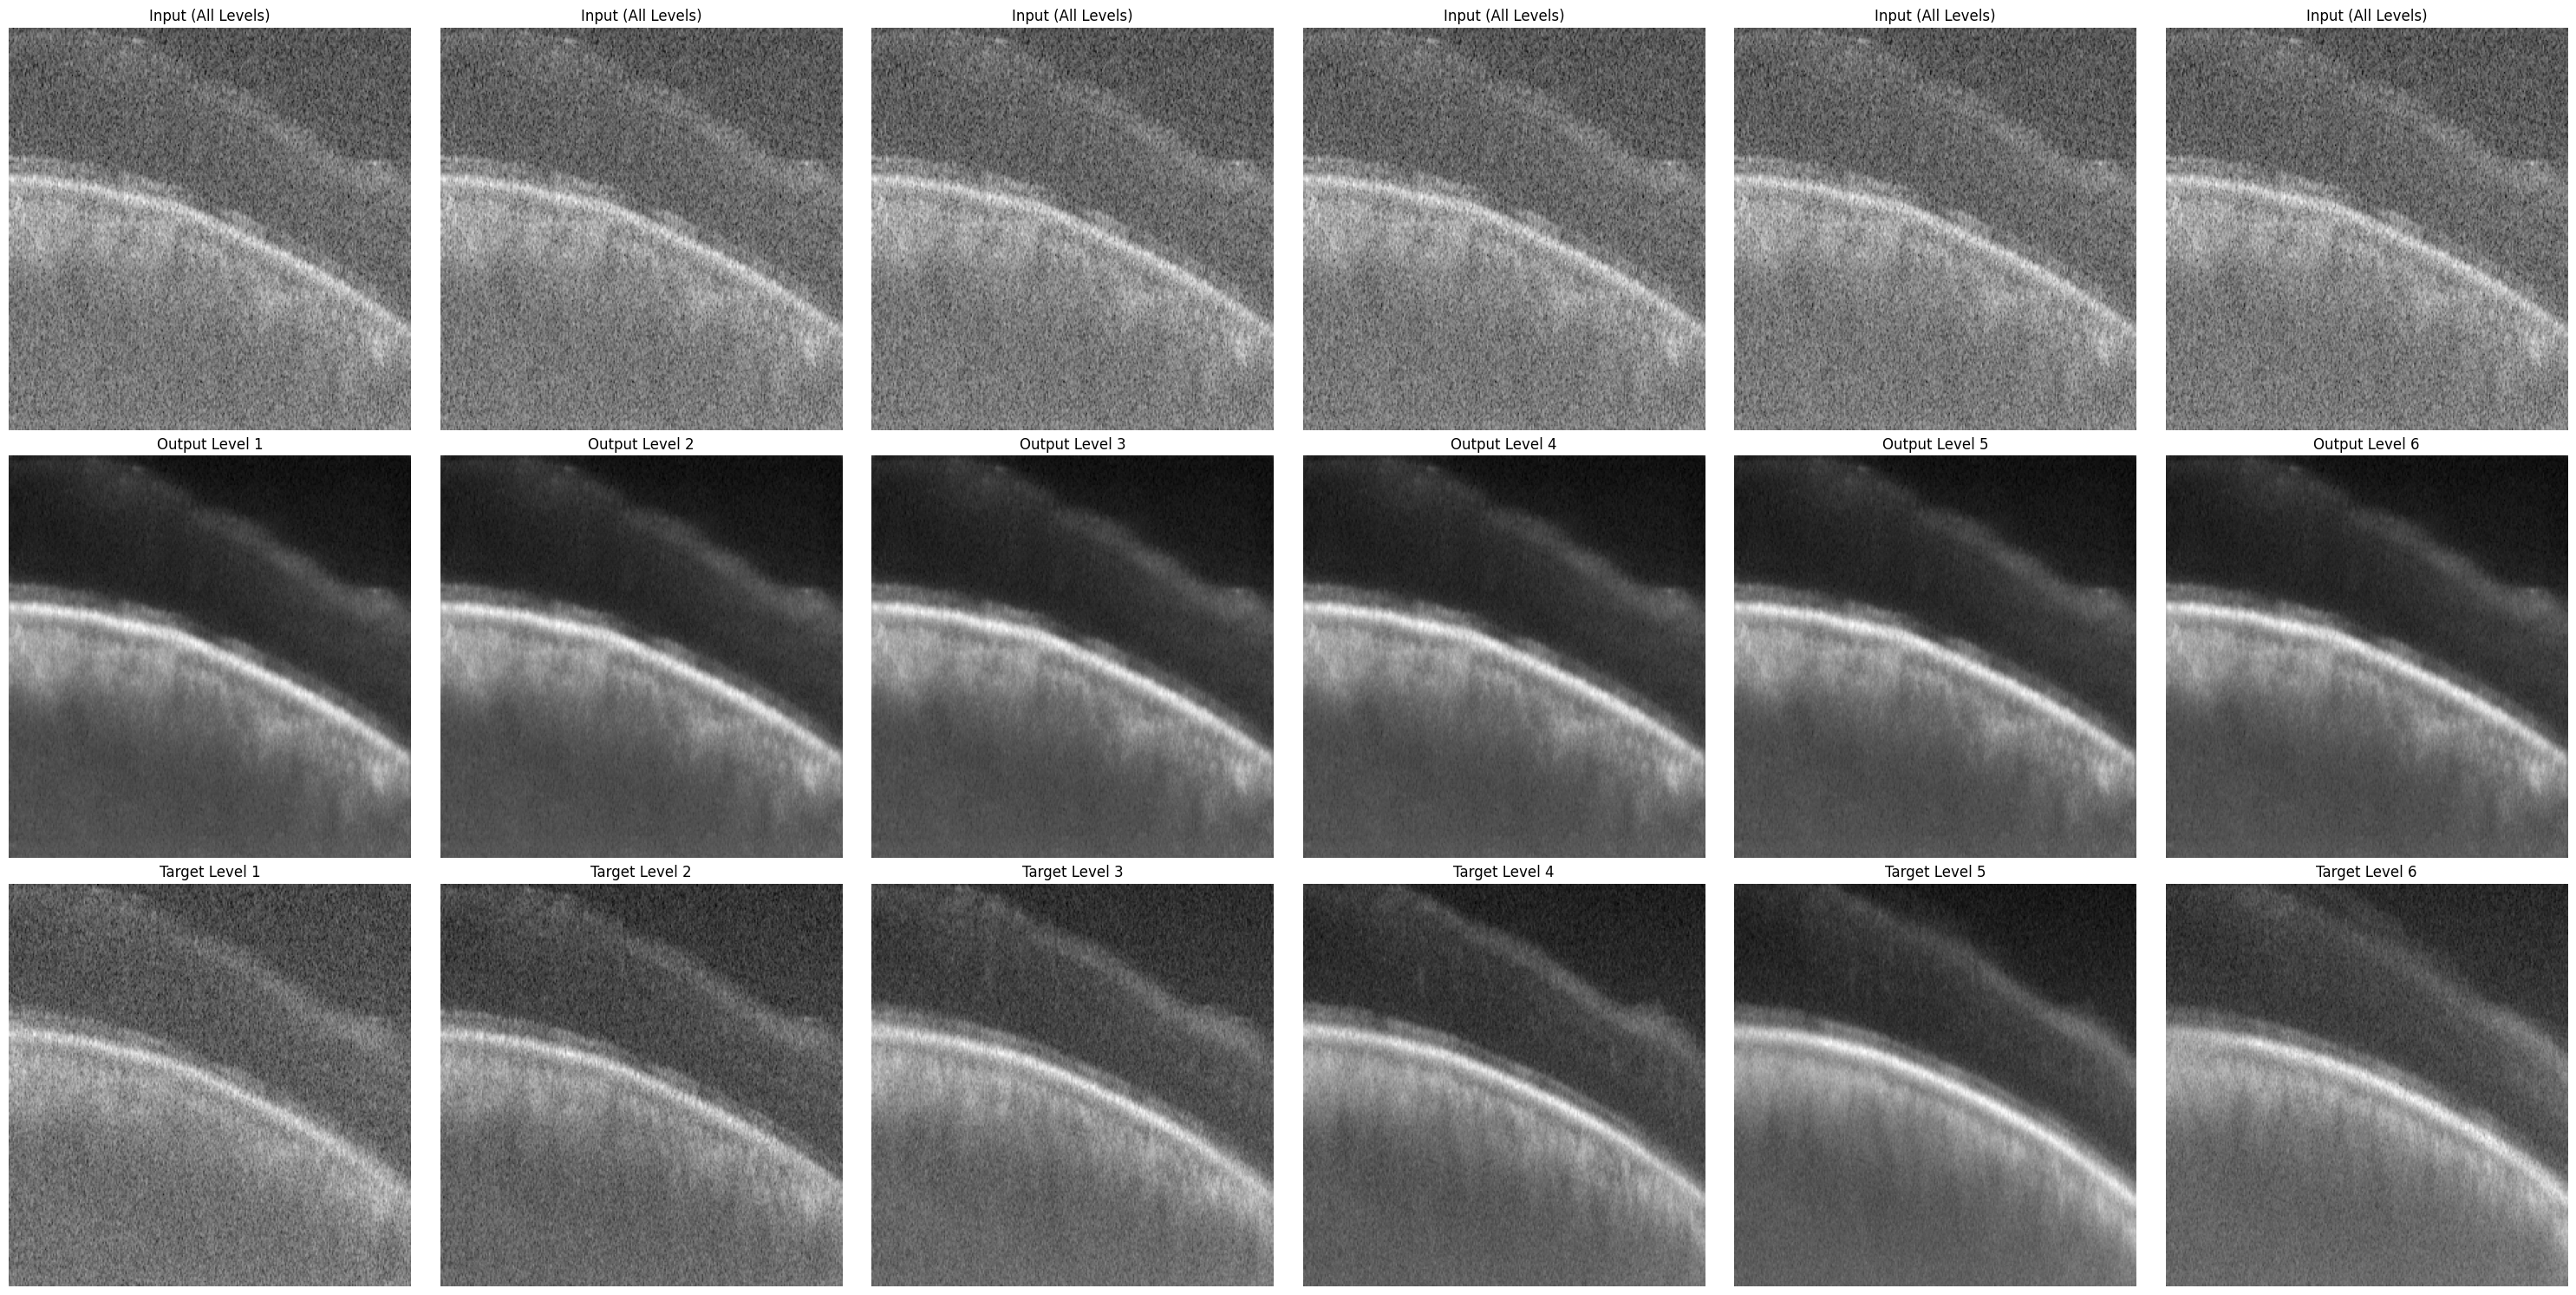

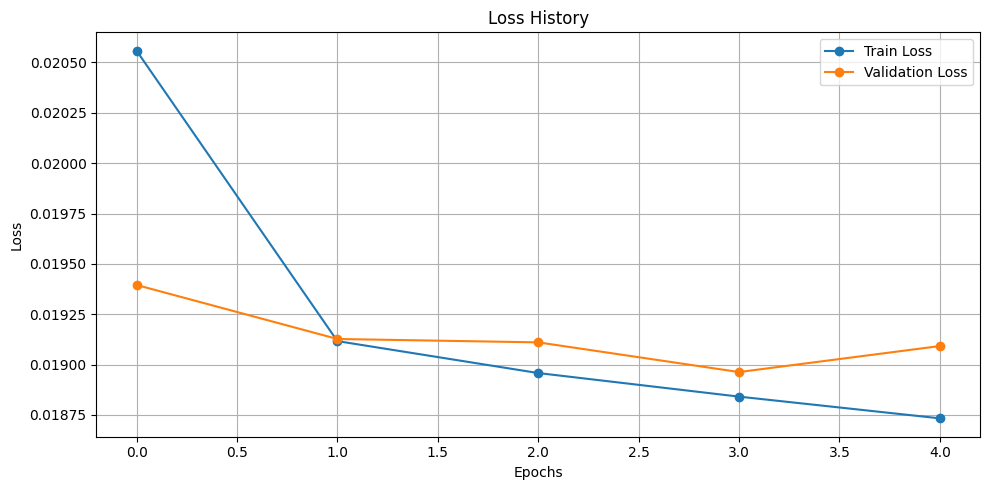

In [10]:

with open('training_history.json', 'r') as f:
    history = json.load(f)

file_path = "saved_batches/epoch_4_batch_0.npz"#f'saved_batches\{os.listdir('saved_batches')[-1]}'#"saved_batches/epoch_14_batch_0.npz"

data = np.load(file_path)
inputs = data['inputs']
outputs = data['outputs']
targets = data['targets']

print("Shapes of inputs, outputs, targets:")
print("Inputs:", inputs.shape)
print("Outputs:", outputs.shape)
print("Targets:", targets.shape)

# Visualise saved batch
visualize_saved_batch(file_path)

# Plot loss history
plot_loss_history(history)

In [11]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# PSNR Implementation
def compute_psnr(input_image, output_image, max_pixel_value=255.0):
    mse = np.mean((input_image - output_image) ** 2)
    if mse == 0:  # Avoid division by zero
        return float('inf')
    psnr = 10 * np.log10(max_pixel_value ** 2 / mse)
    return psnr

# SSIM Implementation
def compute_ssim(input_image, output_image, data_range=255.0, win_size=7):
    score, _ = ssim(input_image, output_image, full=True, data_range=data_range, win_size=win_size)
    return score


# CNR Implementation
def compute_cnr(roi, background):
    roi_mean = np.mean(roi)
    bg_mean = np.mean(background)
    bg_std = np.std(background)
    cnr = abs(roi_mean - bg_mean) / bg_std
    return cnr

(300, 300)
(300, 300)


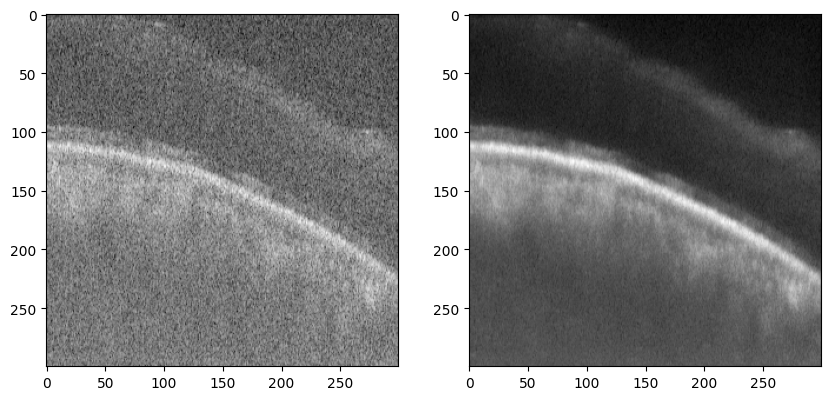

In [12]:
input = inputs[0][0]
output = outputs[0][0][0]

print(input.shape)
print(output.shape)

fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(input, cmap='gray')
ax[1].imshow(output, cmap='gray')

In [13]:
def compute_psnr(input_image, output_image, max_pixel_value=255.0):
    mse = np.mean((input_image - output_image) ** 2)
    if mse == 0:  # Avoid division by zero
        return float('inf')
    psnr = 10 * np.log10(max_pixel_value ** 2 / mse)
    return psnr

def compute_psnr(input_image, output_image, max_pixel_value=255.0):
    mse = np.mean((input_image - output_image) ** 2)
    if mse == 0:  # Avoid division by zero
        return float('inf')
    psnr = 10 * np.log10(max_pixel_value ** 2 / mse)
    return psnr

def compute_cnr(roi, background):
    roi_mean = np.mean(roi)
    bg_mean = np.mean(background)
    bg_std = np.std(background)
    cnr = abs(roi_mean - bg_mean) / bg_std
    return cnr

# Compute PSNR
psnr = compute_psnr(input, output)
print(f"PSNR: {psnr:.2f} dB")

# Compute SSIM
ssim_score = compute_ssim(input, output, data_range=input.max() - input.min())
print(f"SSIM: {ssim_score:.4f}")

# Define ROI and Background (arbitrary example; adjust as needed)
roi = output[100:200, 100:200]  # Example region of interest
background = output[300:400, 300:400]  # Example background region

# Compute CNR
cnr = compute_cnr(roi, background)
print(f"CNR: {cnr:.2f}")


PSNR: 48.76 dB
SSIM: -0.0330
CNR: nan


c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


## TestDataset

In [16]:
test_dataset = get_dataset(basedir='../data/TestDataset', size=img_size, levels=levels)

Processing patient RawDataQA (2) in 0 with 8 levels


In [24]:
test_loader = test_dataset[2]
img = next(iter(test_loader))[0]
img = img[0][0][0]

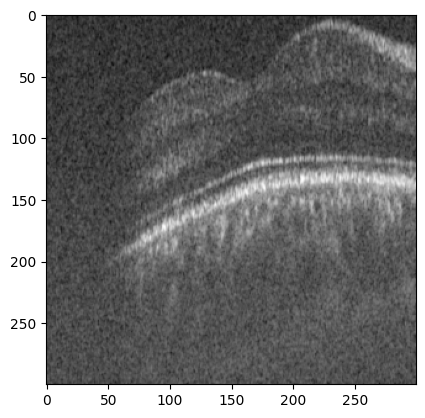

In [25]:
plt.imshow(img, cmap='gray')

In [27]:
device = 'cuda'

output = model(img.unsqueeze(0).unsqueeze(0).to(device), 7, img.shape)

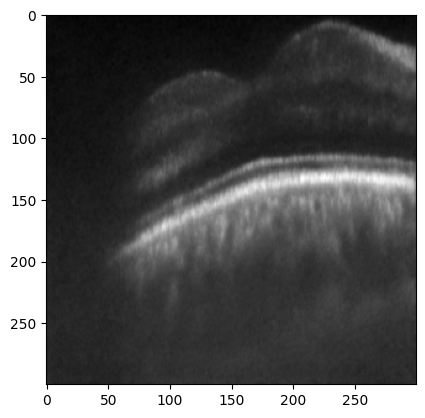

In [29]:
output = output[0][0][0].cpu().detach().numpy()
plt.imshow(output, cmap='gray')

In [33]:
img = img.cpu().detach().numpy()

In [34]:
print(img.shape, output.shape)

(300, 300) (300, 300)


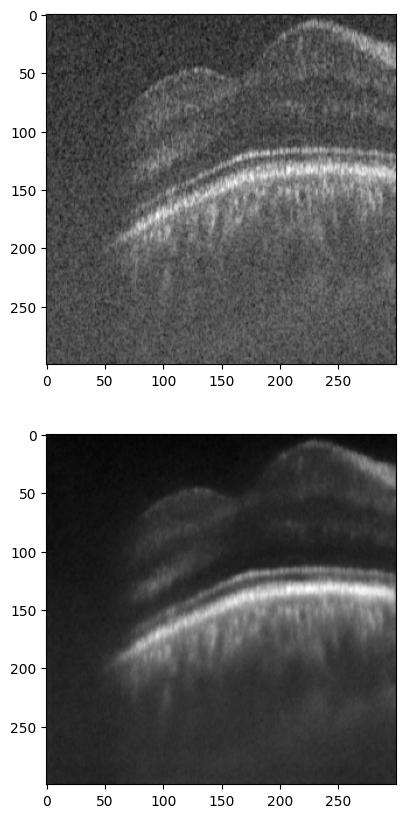

In [41]:
ax, fig = plt.subplots(2,1, figsize=(10,10))
fig[0].imshow(img, cmap='gray')
fig[1].imshow(output, cmap='gray')

In [42]:
import numpy as np

def compute_psnr(noisy_image, denoised_image):
    # Normalize images
    noisy_norm = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min())
    denoised_norm = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
    
    mse = np.mean((noisy_norm - denoised_norm) ** 2)
    if mse == 0:
        return float('inf')
    
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

snr_score = compute_psnr(img, output)

print(f"PSNR: {snr_score:.2f} dB")

PSNR: 17.27 dB


In [43]:
def compute_cnr(noisy_image, denoised_image, roi_mask):
    """
    Compute the Contrast-to-Noise Ratio (CNR).
    
    CNR = | mean_signal - mean_background | / noise_std
    
    Parameters:
        noisy_image (numpy.ndarray): Noisy input image.
        denoised_image (numpy.ndarray): Denoised output image.
        roi_mask (numpy.ndarray): Binary mask (1 for signal region, 0 for background).
    
    Returns:
        float: CNR value.
    """
    signal_region = denoised_image[roi_mask == 1]
    background_region = denoised_image[roi_mask == 0]

    mean_signal = np.mean(signal_region)
    mean_background = np.mean(background_region)
    noise_std = np.std(background_region)  # Noise estimated from background

    if noise_std == 0:
        return float('inf')  # Perfect denoising

    return np.abs(mean_signal - mean_background) / noise_std

cnr_score = compute_cnr(img, output, roi_mask=(img > 0.5).astype(np.uint8))

print(f"CNR: {cnr_score:.2f}")

CNR: 3.43


In [ ]:
import os
from src.utils import mean_fusion
from matplotlib import pyplot as plt

raw_path = r'C:\temp\stage1\0\raw'
constraint_path = r'C:\temp\stage1\0\constraint'

def fuse_images(images, n_neighbours):
    fused_images = []
    pairs = []
    
    for i in range(n_neighbours, len(images) - n_neighbours):
        fused_images = mean_fusion(images, i, n_neighbours)
        pairs.append((i, images[i], fused_images))

    return pairs

from PIL import Image
import numpy as np

raw_datalist = os.listdir(raw_path)
raw_loaded_images = [Image.open(os.path.join(raw_path, f)) for f in raw_datalist]
raw_loaded_images = [np.array(img) for img in raw_loaded_images]
constraint_datalist = os.listdir(constraint_path)
constraint_loaded_images = [Image.open(os.path.join(constraint_path, f)) for f in constraint_datalist]
constraint_loaded_images = [np.array(img) for img in constraint_loaded_images]
fused_data = fuse_images(raw_loaded_images, 10)

In [ ]:
selection = 5
i = fused_data[selection][0]
raw = raw_loaded_images[i][:,:,0]
constraint = constraint_loaded_images[i][:,:,0]
fused = fused_data[selection][2][0][1][:,:,0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(raw, cmap='gray')
ax[0].set_title('Raw')
ax[1].imshow(constraint, cmap='gray')
ax[1].set_title('Constraint')
ax[2].imshow(fused, cmap='gray')
ax[2].set_title('Fused')